In [67]:
import torch
import torchvision

import torch.nn as nn 
import torch.optim as optim

import torch.nn.functional as F
import os
from torch.utils.data import Dataset

### Load data

In [68]:
if not os.path.exists("./files"):
    os.mkdir("./files/")

train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

train_x, train_y = train_data.data, train_data.targets
test_x, test_y = test_data.data, test_data.targets

uq_target = torch.unique(train_y)

train_idx = torch.arange(len(train_x))
test_idx = torch.arange(len(test_x))


test_idx_  = []
train_idx_ = []

for i in torch.arange(len(uq_target)):
    train_select_idx = train_idx[train_y == uq_target[i]]
    train_perm_idx = torch.randperm(len(train_select_idx))
    # 从训练数据中每类随机选择100个作为训练样本
    train_select_idx_ = train_select_idx[train_perm_idx[0:100]]

    train_idx_.append(train_select_idx_)

    test_select_idx = test_idx[test_y == uq_target[i]]
    test_perm_idx = torch.randperm(len(test_select_idx))
    # 从测试数据中每类随机选择200个作为测试样本
    test_select_idx_ = test_select_idx[test_perm_idx[0:200]]

    test_idx_.append(test_select_idx_)

train_idx_ = torch.cat(train_idx_)

test_idx_ = torch.cat(test_idx_)


train_data_ = tuple([train_x[train_idx_], train_y[train_idx_]])
test_data_ = tuple([test_x[test_idx_], test_y[test_idx_]])

class myMNIST(Dataset):
    def __init__(self, data):
        self.x = data[0].float()
        self.label = data[1]
    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):
        x = self.x[index]
        label = self.label[index]

        return x, label
    
train_dataset = myMNIST(train_data_)
test_dataset = myMNIST(test_data_)

x, y = train_dataset[0]


batch_size_train = 1000 # 训练集全批量
batch_size_test = 2000  # 测试集全批量
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

torch.Size([28, 28])


### Show examples

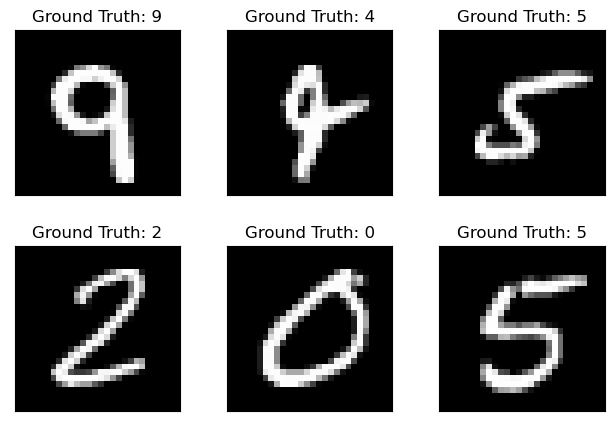

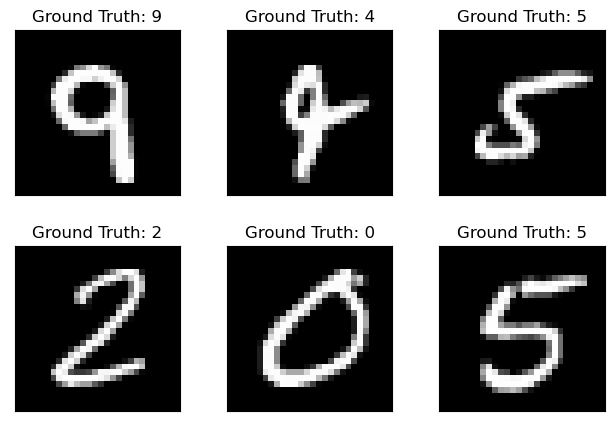

In [69]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Define MLP model

In [70]:
class MLP(nn.Module):
    def __init__(self, input_dim, ouput_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, ouput_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        h_1 = F.relu(self.input_fc(x))

        h_2 = F.relu(self.hidden_fc(h_1))

        y_pred = self.output_fc(h_2)

        return y_pred, h_2

### Count the total number of learnable parameters

In [71]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)
print(f'The model has {count_parameters(model):,} learnable paraemters')

The model has 222,360 learnable paraemters


### Implement gradient descent

In [72]:
def gradient_descent(model, learning_rate):
    with torch.no_grad():
        for p in model.parameters():
            if p.requires_grad:
                p.copy_(p.data - learning_rate * p.grad)
                p.grad.zero_()

### Define evaluation


In [73]:
criterion = nn.CrossEntropyLoss()

def cal_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]

    return acc

### Train model

In [74]:
def train(model, data_loader, criterion, learning_rate):
    epoch_loss, epoch_acc = 0.0, 0.0
    model.train()

    for X, y in data_loader:
        y_pred, _ = model(X)
        loss = criterion(y_pred, y)
        acc = cal_accuracy(y_pred.data, y)

        loss.backward()

        gradient_descent(model, learning_rate)

        epoch_loss += loss.item()
        epoch_acc += acc
    
    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)


def eval(model, data_loader, criterion):
    epoch_loss, epoch_acc = 0.0, 0.0
    model.eval()

    with torch.no_grad():
        for X, y in data_loader:
            y_pred, _ = model(X)
            loss = criterion(y_pred, y)
            acc = cal_accuracy(y_pred.data, y)

            epoch_loss += loss.item()
            epoch_acc += acc
    
    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [75]:
EPOCHS = 100
learning_rate = 1e-3

import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

train_loss_, test_loss_ = [], []
train_acc_, test_acc_ = [], []

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, criterion, learning_rate)
    test_loss, test_acc = eval(model, test_loader, criterion)

    train_loss_.append(train_loss)
    test_loss_.append(test_loss)

    train_acc_.append(train_acc)
    test_acc_.append(test_acc)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 14.244 | Train Acc: 11.60%
	 Test Loss: 9.674 |  Test Acc: 15.35%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 9.243 | Train Acc: 16.10%
	 Test Loss: 7.697 |  Test Acc: 19.70%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 7.483 | Train Acc: 21.60%
	 Test Loss: 5.308 |  Test Acc: 26.50%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 5.032 | Train Acc: 27.60%
	 Test Loss: 3.750 |  Test Acc: 31.50%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.539 | Train Acc: 33.00%
	 Test Loss: 2.762 |  Test Acc: 41.60%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 2.460 | Train Acc: 44.30%
	 Test Loss: 2.342 |  Test Acc: 45.65%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.072 | Train Acc: 48.10%
	 Test Loss: 2.121 |  Test Acc: 49.85%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 1.789 | Train Acc: 55.50%
	 Test Loss: 1.930 |  Test Acc: 52.30%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 1.594 | Train Acc: 58.90%
	 Test Loss: 1.810 |  Test Acc: 54.55%
Epoch: 10 | Epoch Time: 0m 

### Visulize the training processing

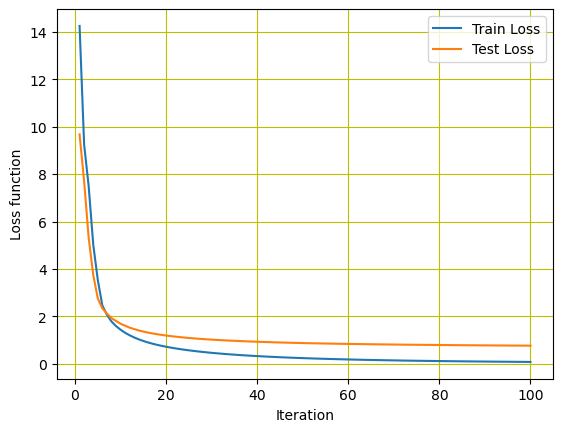

In [76]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
plt.plot(np.arange(1, EPOCHS+1), train_loss_, label="Train Loss")
plt.plot(np.arange(1, EPOCHS+1), test_loss_, label="Test Loss")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss function")
plt.grid('True', color='y')
plt.show()

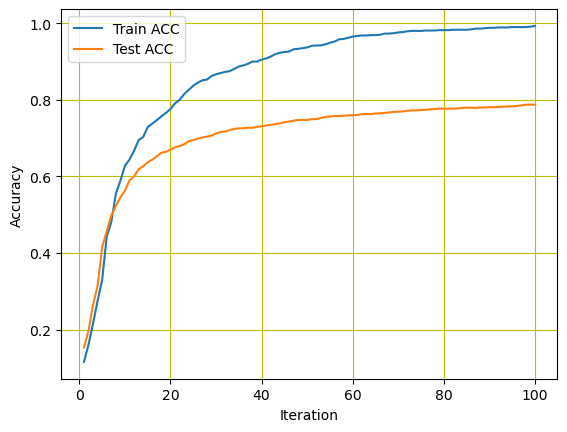

In [77]:
fig = plt.figure()
plt.plot(np.arange(1, EPOCHS+1), train_acc_, label="Train ACC")
plt.plot(np.arange(1, EPOCHS+1), test_acc_, label="Test ACC")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid('True', color='y')
plt.show()
